<a href="https://colab.research.google.com/github/junhyeokk/boomhill24/blob/main/model/baseline-model-train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import csv
import random
import glob
import numpy as np
from PIL import Image as PIL_Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torch.autograd import Variable

from torchvision import transforms
from torchvision.models import resnet50, resnet152

In [ ]:
seed = 400

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)    
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
drivepath = "/content/gdrive/MyDrive"
shared_drivepath = "/content/gdrive/Shareddrives/umapyoi"

In [ ]:
device_type = "cuda" if torch.cuda.is_available() else "cpu"
# device_type = "cpu"
device = torch.device(device_type)
print(device)

cuda


## 모델 설정

In [ ]:
class KartModel1(nn.Module):
  def __init__(self, class_num = 8):
    super(KartModel1, self).__init__()
    self.class_num = class_num
    self.backbone = resnet152(pretrained=True)
    in_features_num = self.backbone.fc.in_features
    
    self.backbone.fc = nn.Sequential(
      nn.Linear(in_features=in_features_num, out_features=256, bias=True),
      nn.BatchNorm1d(256),
      nn.ReLU(),
      nn.Linear(in_features=256, out_features=class_num, bias=True),
      # nn.Softmax(dim=1)
      # nn.Sigmoid(),
    )
  
  def forward(self, input_image):
    output = self.backbone(input_image)

    return output

In [ ]:
class KartDataSet1(data.Dataset):
  def __init__(self, csv_files):
    self.images = []
    self.labels = []

    for csv_file in csv_files:
      with open(csv_file) as csvfile:
        csv_reader = csv.reader(csvfile)
        # next(csv_reader, None)        # 첫번째 row 스킵
        
        image_path = '/' + '/'.join(csv_file.split('/')[:-1]) + "/img/"
        for row in csv_reader:
          self.images.append(image_path + row[0])
          # self.labels.append([int(x) for x in list(row[1][:3])])
          self.labels.append(int(row[1][:3], 2))

  def __getitem__(self, index):
    image_path = self.images[index]
    image = PIL_Image.open(image_path)

    label = self.labels[index]

    preprocess = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),     # -1 ~ 1 로 normalize
    ])
    
    return preprocess(image), label

  def __len__(self):
    return len(self.images)

In [ ]:
train_csvs = []
for csv_file in glob.glob(f"{shared_drivepath}/simpleCNNdata/**/*.csv"):
  train_csvs.append(csv_file)
print(len(train_csvs))
print(train_csvs[0])

54
/content/gdrive/Shareddrives/umapyoi/simpleCNNdata/ice_penguin/test.csv


In [ ]:
train_dataset = KartDataSet1(train_csvs)
print(len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1])

58683
torch.Size([3, 224, 224])
0


In [ ]:
num_epochs = 5
lr = 1e-4
batch_size = 32
log_interval = 20

In [ ]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size = batch_size,
    num_workers = 4,
    shuffle = True
)

print(len(train_loader))

1834


In [ ]:
model = KartModel1()

for param, weight in model.named_parameters():
  print(f"param {param:20} required gradient? -> {weight.requires_grad}")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

param backbone.conv1.weight required gradient? -> True
param backbone.bn1.weight  required gradient? -> True
param backbone.bn1.bias    required gradient? -> True
param backbone.layer1.0.conv1.weight required gradient? -> True
param backbone.layer1.0.bn1.weight required gradient? -> True
param backbone.layer1.0.bn1.bias required gradient? -> True
param backbone.layer1.0.conv2.weight required gradient? -> True
param backbone.layer1.0.bn2.weight required gradient? -> True
param backbone.layer1.0.bn2.bias required gradient? -> True
param backbone.layer1.0.conv3.weight required gradient? -> True
param backbone.layer1.0.bn3.weight required gradient? -> True
param backbone.layer1.0.bn3.bias required gradient? -> True
param backbone.layer1.0.downsample.0.weight required gradient? -> True
param backbone.layer1.0.downsample.1.weight required gradient? -> True
param backbone.layer1.0.downsample.1.bias required gradient? -> True
param backbone.layer1.1.conv1.weight required gradient? -> True
para

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

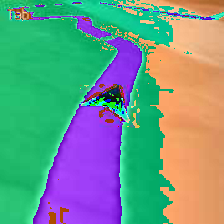

tensor([4, 7, 7, 1, 7, 3, 7, 7, 1, 1, 1, 0, 7, 1, 1, 1, 1, 7, 1, 1, 7, 4, 7, 2,
        1, 7, 1, 0, 1, 1, 1, 7], device='cuda:0')
tensor([6, 4, 4, 5, 4, 4, 4, 6, 6, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 1, 4, 5], device='cuda:0')
tensor(2, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

it = iter(train_loader)
inputs, labels = next(it)
display(to_img(inputs[0]))

inputs = inputs.to(device)
labels = labels.to(device)
outs = model(inputs)
preds = torch.argmax(outs, dim=-1)
print(preds)
print(labels)
print((preds == labels).sum())

loss = criterion(outs, labels)

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 133 kB 62.6 MB/s 
     |████████████████████████████████| 97 kB 8.2 MB/s 
     |████████████████████████████████| 180 kB 53.1 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=f55589500d3a8f43e108166f7bad910eb7ee452fda954396118e186006d63791
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=eda5358e48448e9bb8ac8c1311a5e42cf2d43bbdedf88dd473cfbaa606f04782
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
config = {}
config['n_epochs'] = num_epochs
config['batch_size'] = batch_size
config['lr'] = lr

wandb.init(project="boomhill24_14", config=config)

wandb: Currently logged in as: junhyeokk (use `wandb login --relogin` to force relogin)


In [ ]:
for epoch in range(num_epochs):
  model.train()
  loss_value = 0
  matches = 0

  for idx, train_batch in enumerate(train_loader):
    inputs, labels = train_batch
    inputs = inputs.to(device)
    labels = labels.to(device)

    outs = model(inputs)
    preds = torch.argmax(outs, dim = -1)
    loss = criterion(outs, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_value += loss.item()
    matches += (preds == labels).sum().item()

    if (idx + 1) % log_interval == 0:
      train_loss = loss_value / batch_size / log_interval
      train_acc = matches / batch_size / log_interval
      current_lr = scheduler.get_last_lr()

      wandb.log({"epoch" : epoch, "training_loss" : train_loss, "training_acc" : train_acc, "lr" : current_lr})
      print(
          f"Epoch[{epoch + 1}/{num_epochs}]({idx + 1}/{len(train_loader)}) || ",
          f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%} || lr {current_lr}"
      )

      loss_value = 0
      matches = 0

    scheduler.step()
  
  torch.save(model.state_dict(), f"{shared_drivepath}/simpleCNN_ep{epoch}.pt")

Epoch[1/5](20/1834) ||  training loss 0.06026 || training accuracy 40.31% || lr [6.840622763423389e-05]
Epoch[1/5](40/1834) ||  training loss 0.05168 || training accuracy 58.75% || lr [1.1474337861210536e-05]
Epoch[1/5](60/1834) ||  training loss 0.04708 || training accuracy 64.69% || lr [7.78360372489924e-06]
Epoch[1/5](80/1834) ||  training loss 0.04707 || training accuracy 64.06% || lr [6.243449435824273e-05]
Epoch[1/5](100/1834) ||  training loss 0.04114 || training accuracy 68.12% || lr [9.990133642141353e-05]
Epoch[1/5](120/1834) ||  training loss 0.0344 || training accuracy 72.03% || lr [6.840622763423391e-05]
Epoch[1/5](140/1834) ||  training loss 0.03247 || training accuracy 73.59% || lr [1.147433786121053e-05]
Epoch[1/5](160/1834) ||  training loss 0.03433 || training accuracy 72.03% || lr [7.783603724899249e-06]
Epoch[1/5](180/1834) ||  training loss 0.03125 || training accuracy 74.38% || lr [6.243449435824274e-05]
Epoch[1/5](200/1834) ||  training loss 0.03131 || training a